<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#A4-Neural-Network-Classifier" data-toc-modified-id="A4-Neural-Network-Classifier-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>A4 Neural Network Classifier</a></span><ul class="toc-item"><li><span><a href="#NeuralNetworkClassifier" data-toc-modified-id="NeuralNetworkClassifier-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span><code>NeuralNetworkClassifier</code></a></span></li><li><span><a href="#percent_correct" data-toc-modified-id="percent_correct-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span><code>percent_correct</code></a></span></li><li><span><a href="#Apply-NeuralNetworkClassifier-to-Images-of-Handwritten-Digits" data-toc-modified-id="Apply-NeuralNetworkClassifier-to-Images-of-Handwritten-Digits-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Apply <code>NeuralNetworkClassifier</code> to Images of Handwritten Digits</a></span></li><li><span><a href="#Define-train_for_best_validation-and-apply-to-MNIST-data" data-toc-modified-id="Define-train_for_best_validation-and-apply-to-MNIST-data-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Define <code>train_for_best_validation</code> and apply to MNIST data</a></span></li></ul></li><li><span><a href="#Grading" data-toc-modified-id="Grading-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Grading</a></span></li><li><span><a href="#Extra-Credit" data-toc-modified-id="Extra-Credit-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Extra Credit</a></span></li></ul></div>

# A4 Neural Network Classifier


SURAJ ESWARAN

Classification involves predicting which class an item belongs to. Some classifiers are binary, resulting in a yes/no decision. Others are multi-class, able to categorize an item into one of several categories. Classification is a very common use case of machine learning—classification algorithms are used to solve problems like email spam filtering, document categorization, speech recognition, image recognition, and handwriting recognition.

In this context, a neural network is one of several machine learning algorithms that can help solve classification problems. Its unique strength is its ability to dynamically create complex prediction functions, and emulate human thinking, in a way that no other algorithm can. There are many classification problems for which neural networks have yielded the best results.

### Step 1: Import Code Needed In This Notebook

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import optimizers as opt
import sys

### Step 2: Creating Base Class "Neural Network"

In [6]:
class NeuralNetwork():
    def __init__(self, n_inputs, n_hiddens_list, n_outputs):

        self.n_inputs = n_inputs
        self.n_hiddens_list = n_hiddens_list
        self.n_outputs = n_outputs
        self.n_layers = len(n_hiddens_list) + 1

        self.all_weights, self.Ws = self.make_weights()
        self.initialize_weights()
        self.all_gradients, self.Gs = self.make_weights()

        self.stand_params = None
        self.error_trace = []

    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, {self.n_hiddens_list}, {self.n_outputs})'

    def make_weights(self):
        # Create list of matrix shapes, one per layer
        n_in = self.n_inputs
        units = self.n_hiddens_list + [self.n_outputs]
        shapes = []
        for n_units in units:
            shapes.append((n_in + 1, n_units))
            n_in = n_units

        # Allocate contiguous memory to hold all weights
        n_weights = sum([ni * nu for (ni, nu) in shapes])
        all_weights = np.zeros(n_weights)

        # Create numpy views into this memory with the appropriate
        # shapes to be our weight matrices.
        Ws = []
        first = 0
        for (ni, nu) in shapes:
            n_w = ni * nu
            W = all_weights[first:first + n_w].reshape(ni, nu)
            Ws.append(W)
            first += n_w

        return all_weights, Ws

    def initialize_weights(self):
        for W in self.Ws:
            ni, nu = W.shape
            W[:] = np.random.uniform(-1, 1, size=(ni, nu)) / np.sqrt(ni)
        self.error_trace = []

    def forward(self,Xst):
        Ys = [Xst]
        for layer_i, W in enumerate(self.Ws):
            X = Ys[-1]
            Y = self.add_ones(X) @ W
            if layer_i < self.n_layers - 1:
                Y = np.tanh(Y)
            Ys.append(Y)
        return Ys[1:]  # remove X from Ys

    def backward(self, Xst, Tst):
        n_samples = Xst.shape[0]

        Ys = self.forward(Xst)
        Ys = [Xst] + Ys  # Ys now has n_layers + 1 elements.  Ws still has n_layers elements.
        delta = - (Tst - Ys[-1]) / (n_samples * self.n_outputs)
        for layeri in range(self.n_layers)[::-1]:
            X = Ys[layeri]
            self.Gs[layeri][:] = self.add_ones(X).T @ delta
            if layeri > 0:
                delta = delta @ self.Ws[layeri][1:, :].T
                Y = X  # Ys[layeri]
                delta *= 1 - Ys[layeri] ** 2
            # if layeri < self.n_layers - 1:
            #     delta *= 1 - Y ** 2
        # print(self.all_gradients)
        return self.all_gradients

    def mse(self, Xst, Tst):
        Yst = self.forward(Xst)
        return 0.5 * np.mean((Tst - Yst[-1])**2)

    def train(self, X, T, n_epochs, learning_rate=0.01, method='scg', verbose=True):

        self.stand_params = self.calc_standardize_parameters(X, T)
        Xst = self.standardize_X(X)
        Tst = self.standardize_T(T)

        if method == 'sgd':
            optimizer = opt.Optimizers(self.all_weights).sgd
        elif method == 'adam':
            optimizer = opt.Optimizers(self.all_weights).adam
        elif method == 'scg':
            optimizer = opt.Optimizers(self.all_weights).scg
        else:
            print('train: method must be \'sgd\', \'adam\', or \'scg\'.')

        def error_convert(err):
            if T.shape[1] == 1:
                return np.sqrt(err) * self.stand_params['Tstds']
            else:
                # Can't unstandardize err if more than one network output
                return np.sqrt(err)
            
        error_trace = optimizer(self.mse, self.backward, [Xst, Tst],
                                n_epochs, learning_rate,
                                error_convert_f=error_convert,
                                verbose=verbose)
        self.error_trace += error_trace
        return self

    def use(self, X, return_hidden_layer_outputs=False):
        Xst = self.standardize_X(X)
        Ys = self.forward(Xst)
        Y = Ys[-1]
        Y = self.unstandardize_T(Y)
        Zs = Ys[:-1]
        return (Y, Zs) if return_hidden_layer_outputs else Y

    def get_error_trace(self):
        return self.error_trace

    def add_ones(self, X):
        return np.insert(X, 0, 1, axis=1)

    def calc_standardize_parameters(self, X, T):
        Xmeans = X.mean(axis=0)
        Xstds = X.std(axis=0)
        Xstds[Xstds == 0] = np.mean(Xstds[Xstds > 0])
        Tmeans = T.mean(axis=0)
        Tstds = T.std(axis=0)
        self.stand_params= {'Xmeans': Xmeans, 'Xstds': Xstds, 'Tmeans': Tmeans, 'Tstds': Tstds}
        return {'Xmeans': Xmeans, 'Xstds': Xstds, 'Tmeans': Tmeans, 'Tstds': Tstds}

    def standardize_X(self, X):
        return (X - self.stand_params['Xmeans']) / self.stand_params['Xstds']

    def unstandardize_X(self, Xst):
        return Xst * self.stand_params['Xstds'] + self.stand_params['Xmeans']

    def standardize_T(self, T):
        return (T - self.stand_params['Tmeans']) / self.stand_params['Tstds']

    def unstandardize_T(self, Tst):
        return Tst * self.stand_params['Tstds'] + self.stand_params['Tmeans']

### Step 3: Creating a Sub Class "Neural Network Classifier"

In [7]:
#We have to define a new class that inherits from the base class "Neural Network"
class NeuralNetworkClassifier(NeuralNetwork):     
        
    # Override base class implementation to do nothing
    #def _standardizeT(self, T):
        #return T
    
    # Override base class implementation to do nothing
    #def _unstandardizeT(self, T):
        #return T
   
     #def __init_subclass__(self, n_inputs, n_hiddens_list, n_outputs):
#         super().__init__()

    #def forward(self,Xst):
#         Ys = [Xst]
#         for layer_i, W in enumerate(self.Ws):
#             X = Ys[-1]
#             Y = self.add_ones(X) @ W
# #             if layer_i < self.n_layers - 1:
#             Y = np.tanh(Y)
#             Ys.append(Y)
# #         return Ys[1:]
# #         Ys = super().forward(X)
# #         Y = super().add_ones(Ys[-1]) @ self.Ws[-1]
#         Ys[-1] = self.softmax(Ys[-1])
#         return Ys[1:]
        
        #Zs=[] 
        #for i in self.Ws[:-1]:
            #Z=np.tanh(self.add_ones(Xst) @ i)
            #Zs.append(Z)
            #Xst = Z
        #self.Yst = self.add_ones(Z) @ self.Ws[-1]
        #Y = self.softmax(self.Yst)
        #Zs.append(Y)
        #return Zs
    
    def forward(self,X):
        Ys = [X]
        for layer_i, W in enumerate(self.Ws):
            X = Ys[-1]
            Y = self.add_ones(X) @ W
            if layer_i < self.n_layers - 1:
                Y = np.tanh(Y)
                Ys.append(Y)
            else:
                Y = self.softmax(Y)
                Ys.append(Y)
                
        return Ys[1:]  # remove X from Ys

      
    def make_indicator_variables(self, T):
        # Make sure T is two-dimensional. Should be nSamples x 1.
        if T.ndim == 1:
            T = T.reshape((-1,1))    
        return (T == np.unique(T)).astype(int)
        
    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = max(0, np.max(Y))
        expY = np.exp(Y - maxY)
        denom = np.sum(expY, axis=1).reshape((-1, 1)) 
        Y = expY / (denom + sys.float_info.epsilon)             # requires an    import sys
        return Y
    
    def neg_log_likelihood(self, X, T):
        Ys = self.forward(X)
        #Y = self.softmax(Ys[-1])
#         log_likelihood = 0
#         if T is not None:
        log_likelihood = (T*(np.log(Ys[-1]+sys.float_info.epsilon)))
        return -(np.mean(log_likelihood))
        
        
    def train(self, X, T, n_epochs, learning_rate=0.01, method='scg', verbose=True):
        #One change is that we are not standardizing our targets. Our targets are going to be integers 
        
        self.stand_params = self.calc_standardize_parameters(X, T)
        Xst = self.standardize_X(X)
        
        self.classes, counts = np.unique(T, return_counts=True)
        self.most_common_class = self.classes[np.argmax(counts)]

        if self.n_outputs != len(self.classes):
            raise ValueError(f'''In NeuralNetworkClassifier, 
            the number of outputs must equal the number of classes in the training data. 
            The given number of outputs is {self.n_outputs} and number of classes is {len(self.classes)}.
            Try changing the number of outputs in the call to NeuralNetworkClassifier().''')

        # Convert targets into indicator variables
        T_ind_vars = self.make_indicator_variables(T)
        
#         def error_convert(neg_log_likelihood):
#         if T.shape[1] == 1:
#             return self.sqrt(neg_log_likelihood) * self.stand_params['Tstds']
#         else:
#         # Can't unstandardize err if more than one network output
#             #print(neg_log_likelihood) 
#             return np.sqrt(-neg_log_likelihood)
        if method == 'sgd':
            optimizer = opt.Optimizers(self.all_weights).sgd
        elif method == 'adam':
            optimizer = opt.Optimizers(self.all_weights).adam
        elif method == 'scg':
            optimizer = opt.Optimizers(self.all_weights).scg
        else:
            print('train: method must be \'sgd\', \'adam\', or \'scg\'.')
            
        def error_convert(negLL):
            return np.exp(-negLL)
        
        error_trace = optimizer(self.neg_log_likelihood, self.backward, [Xst, T_ind_vars],
                                     n_epochs, learning_rate,error_convert_f=error_convert,verbose=verbose)
        
        self.error_trace += error_trace
        return self
    
    def use(self, X, return_hidden_layer_outputs=False):
        Xst = self.standardize_X(X)
        Ys = self.forward(Xst)
        Y = Ys[-1]
#         Y = self.unstandardize_T(Y)
        classes = np.argmax(Y, axis=1).reshape(-1, 1)
        Zs = Ys[:-1]
        # Convert Y to 'classes' 
        # - argmax returns an index into the class array, not the value
#         Y_class_idx = list(self.argmax(Y, axis=1))
#         Y_classes = np.array([self.classes[i] for i in Y_class_idx]).reshape((-1,1))
        return (classes, Y, Zs) if return_hidden_layer_outputs else (classes, Y)

### Step 4: Utilizing a function `percent_correct`

When trying to classify real data, we need a way to evaluate our performance.  One way is to just calculate the percent of samples correctly classified, and to show a confusion matrix.  Define the function
`percent_correct(Y, T)`, that returns the percent of samples correctly classified, given `T` as a column matrix of class labels, and `Y` as the column matrix of classes predicted by `use`.

In [8]:
def percent_correct(Y,T):
    cp=0
    n=len(Y)
    for i in range(0,n):
        if(T[i]!=Y[i]):
            cp=cp+1
    cp=n-cp
    p_c=(cp/n)*100
    return p_c

### Step 5: Testing and Evaluation of all the functions

In [425]:
X = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
T = np.array([[0], [1], [1], [0]])
X, T

(array([[0, 0],
        [1, 0],
        [0, 1],
        [1, 1]]),
 array([[0],
        [1],
        [1],
        [0]]))

In [426]:
np.random.seed(111)
nnet = NeuralNetworkClassifier(2, [10], 2)

In [427]:
nnet.forward(Xst)

[array([[-0.65071726, -0.44024437,  0.04576217, -0.42339865, -0.43460927,
         -0.46740829, -0.39822372,  0.71346703,  0.23848393, -0.19208626],
        [ 0.34231299, -0.79254131, -0.72655903, -0.06007838, -0.18346578,
         -0.77314041, -0.46175878,  0.0128676 , -0.62959015,  0.62370478],
        [-0.09735492,  0.30405172,  0.64909581,  0.5928089 , -0.27947188,
          0.2144819 , -0.53935438, -0.19458859,  0.13639376, -0.80263068],
        [ 0.77613968, -0.28371417, -0.19108161,  0.79083647, -0.00711046,
         -0.294489  , -0.59233336, -0.79262132, -0.68931726, -0.1784822 ]]),
 array([[0.4190728 , 0.5809272 ],
        [0.42642212, 0.57357788],
        [0.59859207, 0.40140793],
        [0.59715275, 0.40284725]])]

In [428]:
nnet.neg_log_likelihood(Xst, T_ind)

0.3567414532031946

If you add some print statements in `neg_log_likelihood` functions, you can compare your output to the following results.

In [451]:
nnet.train(X, T, 1, 0.1, 'sgd')

sgd: Epoch 1 Error=0.70711


NeuralNetwork(2, [], 2)

In [452]:
np.exp(-0.35674)

0.6999544622383824

Now if you comment out those print statements, you can run for more epochs without tons of output.

In [453]:
np.random.seed(111)
nnet = NeuralNetworkClassifier(2, [10], 2)

In [454]:
nnet.train(X, T, 100, method='scg')

SCG: Epoch 9 Error=0.99066
SCG: Epoch 19 Error=0.99994
SCG: Epoch 29 Error=1.00000


NeuralNetwork(2, [10], 2)

In [455]:
nnet.use(X)

(array([[0],
        [1],
        [1],
        [0]], dtype=int64),
 array([[9.99999987e-01, 1.28279496e-08],
        [1.01062442e-08, 9.99999990e-01],
        [8.80561778e-09, 9.99999991e-01],
        [9.99999979e-01, 2.13188123e-08]]))

In [456]:
percent_correct(nnet.use(X)[0], T)

100.0

Works!  The XOR problem was used early in the history of neural networks as a problem that cannot be solved with a linear model.  Let's try it.  It turns out our neural network code can do this if we use an empty list for the hidden unit structure!

In [443]:
nnet = NeuralNetworkClassifier(2, [], 2)
nnet.train(X, T, 100)   # default method is 'scg'

NeuralNetwork(2, [], 2)

In [444]:
nnet.use(X)

(array([[1],
        [0],
        [1],
        [0]], dtype=int64),
 array([[0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5]]))

In [445]:
percent_correct(nnet.use(X)[0], T)

50.0

A second way to evaluate a classifier is to calculate a confusion matrix. This shows the percent accuracy for each class, and also shows which classes are predicted in error.

Here is a function you can use to show a confusion matrix.

In [9]:
import pandas

def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pandas.DataFrame(table, index=class_names, columns=class_names)
    # cf.style.background_gradient(cmap='Blues').format("{:.1f} %")
    print('Percent Correct')
    return conf_matrix.style.background_gradient(cmap='Blues').format("{:.1f}")

In [383]:
confusion_matrix(nnet.use(Xtrain)[0], Ttrain)

Percent Correct


,0,1,2,3,4,5,6,7,8,9
0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0


### Step 6: Apply `NeuralNetworkClassifier` to Images of Handwritten Digits

Apply your `NeuralNetworkClassifier` to the [MNIST digits dataset](http://deeplearning.net/tutorial/gettingstarted.html).

In [10]:
import pickle
import gzip
import matplotlib.pyplot as plt

In [11]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 784) (50000, 1) (10000, 784) (10000, 1) (10000, 784) (10000, 1)


In [12]:
28*28

784

In [13]:
def draw_image(image, label):
    plt.imshow(-image.reshape(28, 28), cmap='gray')
    # plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.title(label)

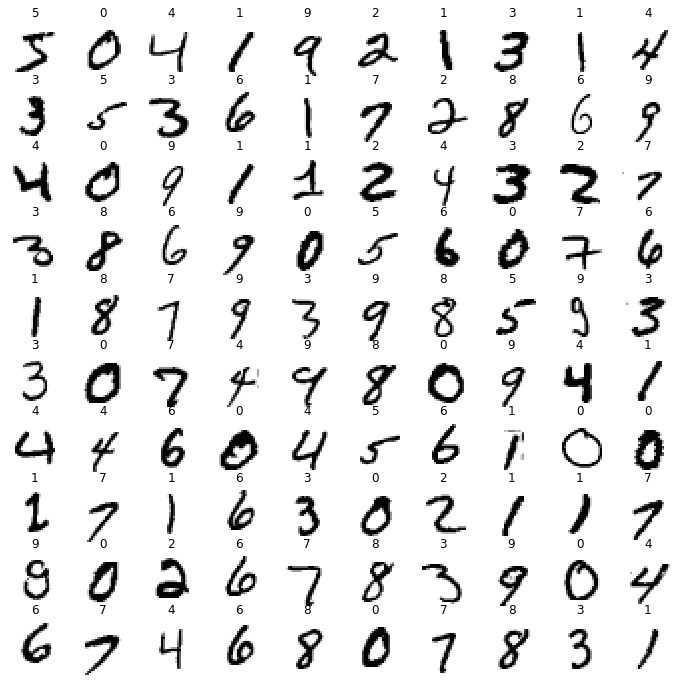

In [14]:
plt.figure(figsize=(12, 12))
for i in range(100):
    plt.subplot(10, 10, i+1)
    draw_image(Xtrain[i], Ttrain[i,0])

In [15]:
nnet = NeuralNetworkClassifier(784, [], 10)
nnet.train(Xtrain, Ttrain, 40)

SCG: Epoch 4 Error=0.95312
SCG: Epoch 8 Error=0.96847
SCG: Epoch 12 Error=0.97195
SCG: Epoch 16 Error=0.97195
SCG: Epoch 20 Error=0.97195
SCG: Epoch 24 Error=0.97238
SCG: Epoch 28 Error=0.97429
SCG: Epoch 32 Error=0.97532
SCG: Epoch 36 Error=0.97629
SCG: Epoch 40 Error=0.97660


NeuralNetwork(784, [], 10)

In [16]:
Xtrain.shape, Ttrain.shape

((50000, 784), (50000, 1))

In [245]:
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest], [Ttrain, Tval, Ttest])]

[92.99199999999999, 92.72, 92.30000000000001]

In [194]:
nnet = NeuralNetworkClassifier(784, [20], 10)
nnet.train(Xtrain, Ttrain, 40)

SCG: Epoch 4 Error=0.93577
SCG: Epoch 8 Error=0.96858
SCG: Epoch 12 Error=0.97701
SCG: Epoch 16 Error=0.98106
SCG: Epoch 20 Error=0.98379
SCG: Epoch 24 Error=0.98580
SCG: Epoch 28 Error=0.98746
SCG: Epoch 32 Error=0.98883
SCG: Epoch 36 Error=0.98992
SCG: Epoch 40 Error=0.99087


NeuralNetwork(784, [20], 10)

In [195]:
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest],
                                                    [Ttrain, Tval, Ttest])]

[97.562, 93.85, 93.69]

In [196]:
Xtrain.shape, Ttrain.shape

((50000, 784), (50000, 1))

### Step 7: Define `train_for_best_validation` and apply to MNIST data

Using the function `run` from Lecture Notes 11 as a guide, define a new function `train_for_best_validation` that accepts arguments
* `Xtrain, Ttrain`: matrices of shapes $N\times D$ and $N\times 1$ as input and target training data, where $N$ is number of training samples and $D$ is number of input components,
* `Xval, Tval`: matrices of shapes  $N\times D$ and $N\times 1$ of validation data ($N$ not same value as above)
* `n_epochs`: total number of epochs to train for,
* `n_epochs_per_train`: divide `n_epochs` by this value to get number of times the neural network `train` function is called for this many epochs,
* `n_hiddens_list`: structure of hidden layers,
* `method`: optimizer method,
* `learning_rate`: used for optimizer methods 'adam' and 'sgd'.

It must return 
* `nnet`: resulting neural network with weights that produced the highest accuracy for the validation data set,
* `epoch`: epoch corresponding to best validation accuracy,
* `train_accuracy`: accuracy at that best epoch on training data,
* `val_accuracy`: accuracy at that best epoch on validation data.

This function should call your `percent_correct` function to calculate classification accuracies.

Apply it to the MNIST data as shown below.

In [321]:
#def rmse(Y, T):
    #print (np.sqrt(np.mean((T-Y)**2))
    #return np.sqrt(np.mean((T-Y)**2))

In [17]:
def train_for_best_validation(Xtrain, Ttrain, Xval, Tval,n_epochs, n_epochs_per_train, n_hiddens_list,method, learning_rate=None):
    n_reps = n_epochs // n_epochs_per_train
    n_epochs_last_train = n_epochs - n_reps * n_epochs_per_train
    if n_epochs_last_train > 0:
        n_reps += 1   
    suraj = NeuralNetworkClassifier(Xtrain.shape[1], n_hiddens_list, len(np.unique(Ttrain)))
    rmses = []
    for reps in range(n_reps):
        n_epoch = n_epochs_per_train 
        if n_epochs_last_train > 0 and reps == n_reps-1:
            n_epoch = n_epochs_last_train
            
        suraj.train(Xtrain, Ttrain, n_epoch, method='scg', verbose=False)
#         print(nnet.use(Xtrain)[0])

        rmses.append([(reps + 1) * n_epoch,
                      percent_correct(suraj.use(Xtrain)[0], Ttrain),
                      percent_correct(suraj.use(Xval)[0], Tval)])
        
    rmses = np.array(rmses)
    best_test_index = np.argmax(rmses[:, -1])
    best_test_epoch, best_test_train_rmse, best_test_test_rmse = rmses[best_test_index, :]
    print(f'Best test error is at epoch {best_test_epoch}', end='')
    print(f' with RMSE Train of {best_test_train_rmse:.2f} and Val of {best_test_test_rmse:.2f}')
    
    plt.plot(rmses[:, 0], rmses[:, 1], label='Train')
    plt.plot(rmses[:, 0], rmses[:, 2], label='Validation')
    plt.legend()
    ymin, ymax = plt.ylim()
    plt.plot([best_test_epoch, best_test_epoch], [ymin, ymax], 'r')
    plt.xlabel(f'Epochs')
    plt.ylabel('RMSE')
    
    return suraj, best_test_epoch, best_test_train_rmse, best_test_test_rmse

Best test error is at epoch 30.0 with RMSE Train of 96.25 and Val of 94.23
Percent Correct


,0,1,2,3,4,5,6,7,8,9
0,99.7,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.1
1,0.0,99.7,0.0,0.0,0.0,0.1,0.0,0.1,0.0,0.0
2,0.1,0.0,99.2,0.1,0.2,0.0,0.2,0.0,0.1,0.0
3,0.0,0.0,0.2,98.9,0.0,0.1,0.0,0.2,0.2,0.2
4,0.0,0.0,0.0,0.0,99.6,0.0,0.0,0.1,0.0,0.1
5,0.1,0.0,0.0,0.1,0.1,99.5,0.1,0.0,0.1,0.0
6,0.1,0.0,0.0,0.0,0.1,0.1,99.6,0.0,0.1,0.0
7,0.0,0.1,0.1,0.1,0.1,0.0,0.0,99.5,0.0,0.1
8,0.0,0.0,0.1,0.2,0.0,0.1,0.0,0.0,99.4,0.1
9,0.0,0.0,0.1,0.1,0.2,0.1,0.0,0.1,0.1,99.3


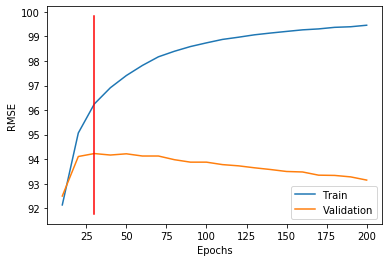

In [20]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 200, 10, [20], method='scg')
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest], [Ttrain, Tval, Ttest])]
confusion_matrix(nnet.use(Xtrain)[0], Ttrain)

Best test error is at epoch 180.0 with RMSE Train of 100.00 and Val of 97.02
Percent Correct


,0,1,2,3,4,5,6,7,8,9
0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0


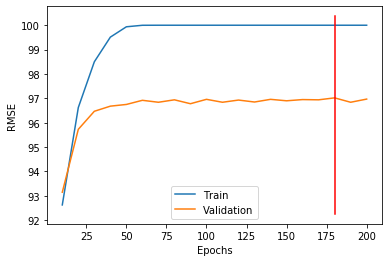

In [21]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 200, 10, [100,100], method='scg') 
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest], [Ttrain, Tval, Ttest])]
confusion_matrix(nnet.use(Xtrain)[0], Ttrain)

Best test error is at epoch 50.0 with RMSE Train of 93.75 and Val of 92.94
Percent Correct


,0,1,2,3,4,5,6,7,8,9
0,97.7,0.0,0.1,0.1,0.2,0.5,0.5,0.1,0.6,0.1
1,0.0,97.6,0.4,0.3,0.1,0.3,0.0,0.2,0.9,0.2
2,0.5,0.9,91.8,1.5,0.9,0.4,0.7,0.9,2.0,0.3
3,0.3,0.5,1.9,91.1,0.1,2.6,0.3,0.8,1.8,0.7
4,0.1,0.3,0.4,0.2,94.6,0.1,0.8,0.2,0.6,2.6
5,0.7,0.5,0.5,2.4,1.0,90.4,1.4,0.3,2.2,0.6
6,0.5,0.2,0.3,0.0,0.5,1.1,96.9,0.1,0.4,0.0
7,0.1,0.4,0.9,0.2,0.8,0.1,0.1,94.8,0.2,2.4
8,0.5,2.0,0.9,2.0,0.5,2.1,0.7,0.2,90.3,0.9
9,0.3,0.5,0.2,1.0,2.0,0.6,0.0,2.4,0.6,92.4


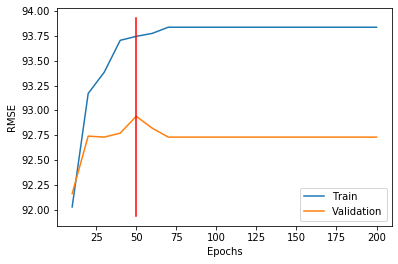

In [22]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 200, 10, [], method='scg')
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest], [Ttrain, Tval, Ttest])]
confusion_matrix(nnet.use(Xtrain)[0], Ttrain)

# adam 

Best test error is at epoch 50.0 with RMSE Train of 97.64 and Val of 94.63
Percent Correct


,0,1,2,3,4,5,6,7,8,9
0,99.8,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.1,0.0
1,0.0,99.8,0.1,0.1,0.0,0.0,0.0,0.1,0.0,0.0
2,0.0,0.0,99.4,0.2,0.2,0.0,0.0,0.0,0.1,0.0
3,0.1,0.0,0.3,99.0,0.0,0.2,0.0,0.2,0.1,0.1
4,0.0,0.0,0.1,0.0,99.7,0.1,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.3,0.1,99.5,0.1,0.0,0.0,0.0
6,0.1,0.0,0.0,0.0,0.1,0.0,99.7,0.0,0.0,0.0
7,0.0,0.1,0.1,0.1,0.0,0.0,0.0,99.7,0.0,0.0
8,0.1,0.0,0.1,0.1,0.0,0.1,0.1,0.0,99.5,0.1
9,0.0,0.0,0.0,0.2,0.2,0.0,0.0,0.1,0.1,99.4


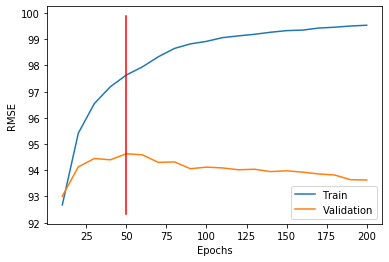

In [23]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 200, 10, [20], method='adam')
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest], [Ttrain, Tval, Ttest])]
confusion_matrix(nnet.use(Xtrain)[0], Ttrain)

Best test error is at epoch 70.0 with RMSE Train of 98.26 and Val of 94.54
Percent Correct


,0,1,2,3,4,5,6,7,8,9
0,99.6,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.0
1,0.0,99.8,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.1,0.2,99.1,0.1,0.1,0.0,0.1,0.2,0.0,0.0
3,0.0,0.0,0.3,99.1,0.1,0.1,0.0,0.1,0.3,0.1
4,0.0,0.0,0.0,0.0,99.5,0.0,0.1,0.0,0.1,0.2
5,0.1,0.0,0.0,0.1,0.0,99.5,0.1,0.0,0.1,0.0
6,0.1,0.0,0.0,0.0,0.1,0.1,99.6,0.0,0.1,0.0
7,0.0,0.1,0.1,0.0,0.1,0.0,0.0,99.6,0.0,0.1
8,0.1,0.0,0.1,0.3,0.0,0.0,0.0,0.0,99.2,0.1
9,0.1,0.0,0.0,0.1,0.2,0.0,0.0,0.1,0.1,99.3


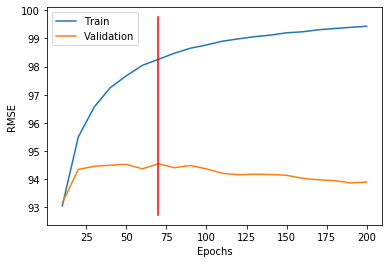

In [24]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain, Xval, Tval,200,10,[20],'adam', 0.01) 
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest], [Ttrain, Tval, Ttest])]
confusion_matrix(nnet.use(Xtrain)[0], Ttrain)

Best test error is at epoch 40.0 with RMSE Train of 96.96 and Val of 94.37
Percent Correct


,0,1,2,3,4,5,6,7,8,9
0,99.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0
1,0.0,99.7,0.1,0.1,0.0,0.0,0.0,0.1,0.0,0.0
2,0.1,0.0,99.2,0.0,0.3,0.0,0.1,0.1,0.1,0.0
3,0.0,0.0,0.1,99.1,0.1,0.1,0.0,0.2,0.2,0.1
4,0.0,0.1,0.1,0.1,99.4,0.0,0.0,0.0,0.0,0.2
5,0.1,0.0,0.0,0.3,0.1,99.4,0.1,0.0,0.1,0.0
6,0.1,0.0,0.0,0.0,0.1,0.1,99.6,0.0,0.0,0.0
7,0.0,0.0,0.1,0.1,0.0,0.0,0.0,99.6,0.0,0.1
8,0.2,0.1,0.0,0.2,0.0,0.1,0.1,0.0,99.2,0.1
9,0.0,0.0,0.0,0.1,0.2,0.1,0.0,0.1,0.2,99.3


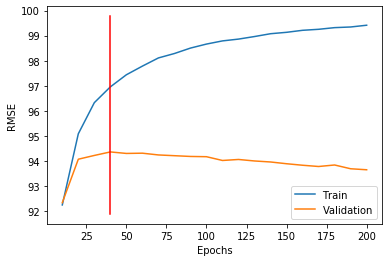

In [25]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain, Xval, Tval,200,10,[20],'adam', 0.05) 
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest], [Ttrain, Tval, Ttest])]
confusion_matrix(nnet.use(Xtrain)[0], Ttrain)

#### SGD 

Best test error is at epoch 50.0 with RMSE Train of 93.67 and Val of 92.92
Percent Correct


,0,1,2,3,4,5,6,7,8,9
0,97.6,0.0,0.2,0.2,0.2,0.5,0.5,0.1,0.6,0.1
1,0.0,97.7,0.4,0.2,0.1,0.3,0.0,0.2,0.9,0.1
2,0.5,0.9,91.9,1.4,1.0,0.3,0.8,1.0,1.9,0.3
3,0.3,0.5,1.8,91.2,0.1,2.6,0.3,0.8,1.8,0.8
4,0.1,0.4,0.5,0.2,94.4,0.1,0.8,0.2,0.5,2.8
5,0.8,0.6,0.6,2.4,0.9,90.4,1.4,0.3,2.0,0.6
6,0.5,0.3,0.4,0.0,0.5,1.0,96.7,0.1,0.4,0.0
7,0.2,0.5,0.9,0.3,0.7,0.1,0.1,94.6,0.2,2.5
8,0.5,2.1,0.9,2.0,0.5,2.1,0.7,0.2,89.9,1.0
9,0.3,0.5,0.3,1.1,2.0,0.6,0.0,2.5,0.6,92.2


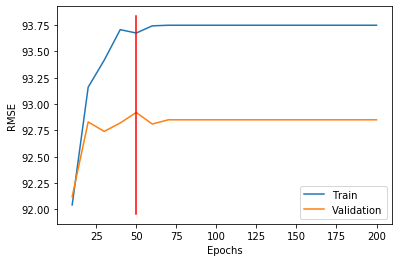

In [26]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain, Xval, Tval,200,10,[],'sgd', 0.01) 
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest], [Ttrain, Tval, Ttest])]
confusion_matrix(nnet.use(Xtrain)[0], Ttrain)

Best test error is at epoch 40.0 with RMSE Train of 93.54 and Val of 92.98
Percent Correct


,0,1,2,3,4,5,6,7,8,9
0,97.6,0.0,0.2,0.2,0.2,0.5,0.6,0.0,0.6,0.1
1,0.0,97.6,0.4,0.3,0.1,0.3,0.0,0.2,0.9,0.1
2,0.6,0.9,91.9,1.4,1.0,0.3,0.8,1.0,1.8,0.3
3,0.3,0.5,1.9,90.9,0.1,2.7,0.3,0.8,1.8,0.8
4,0.2,0.4,0.5,0.1,94.4,0.1,0.8,0.2,0.6,2.8
5,0.8,0.6,0.6,2.3,1.0,90.3,1.4,0.4,2.1,0.6
6,0.6,0.3,0.4,0.0,0.5,1.1,96.5,0.1,0.4,0.1
7,0.2,0.5,0.9,0.3,0.8,0.1,0.1,94.4,0.2,2.6
8,0.6,2.2,1.0,2.0,0.5,2.1,0.7,0.2,89.6,1.1
9,0.3,0.5,0.3,1.1,2.1,0.5,0.0,2.5,0.6,92.0


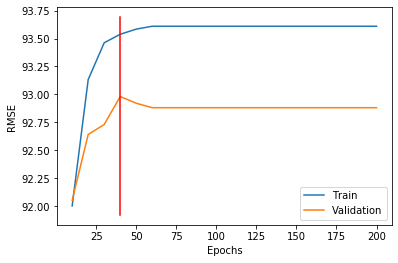

In [27]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain, Xval, Tval,200,10,[],'sgd', 0.05) 
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest], [Ttrain, Tval, Ttest])]
confusion_matrix(nnet.use(Xtrain)[0], Ttrain)

Best test error is at epoch 200.0 with RMSE Train of 100.00 and Val of 96.91
Percent Correct


,0,1,2,3,4,5,6,7,8,9
0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0


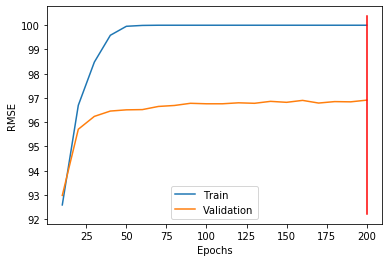

In [28]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain, Xval, Tval,200,10,[100,100],'sgd', 0.01) 
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest], [Ttrain, Tval, Ttest])]
confusion_matrix(nnet.use(Xtrain)[0], Ttrain)

Call `train_for_best_validation` a number of times to compare accuracies using the three different optimization methods, and a few different values of `n_epochs`, `n_epochs_per_train`, and `n_hiddens_list`, and `learning_rate` when using 'sgd' and 'adam'.  You do not have to find the very best values of these parameters.  For example, for `n_hiddens_list` at least use `[]` (a linear model) and a larger network, like `[100, 100]`.

Show the confusion matrix for the network that gave you the best validation accuracy.

Write at least 10 sentences about what you observe in the accuracy plots, the train, validation and test accuracies, and the confusion matrix.

# Result

In [ ]:
data = [["SCG","200", "10","NONE","[]","96.67","94.69"], ["SCG","200", "10","NONE","[100,100]","100","96.87"], ["SCG","200", "10","NONE","[20]","93.73","92.93"], ["ADAM","200", "10","0.01","[]","93.65","92.90"] , ["ADAM","200", "10","0.05","[]","93.67","92.92"] , ["ADAM","200", "10","0.01","[100,100]","100","96.94"] ,["ADAM","200", "10","0.05","[100,100]","100","96.94"], ["ADAM","200", "10","0.01","[20]","98.26","94.77"], ["ADAM","200", "10","0.05","[20]","97.97","94.59"], ["SGD","200", "10","0.01","[]","93.67","92.86"], ["SGD","200", "10","0.05","[]","93.66","92.91"], ["SGD","200", "10","0.01","[100,100]","98.12","94.75"], ["SGD","200", "10","0.05","[100,100]","97.78","94.45"], ["SGD","200", "10","0.01","[20]","100","96.95"], ["SGD","200", "10","0.05","[20]","100","96.96"]]  
pd.DataFrame(data, columns=["Method", "n_epochs","n_epochs_per_train","Learning Rate","n_hidden_list","Training Acuuracy","validation Accuracy"])

1. Gradient Descent minimizes the cost function(RMSE) by performing forward and backward propagation for change weights of the neurons. That is why error value reduces to a near zero at certain epoch based on the hidden layer
2. The aim of this experiment is explore the classification in Neural Networks. 
3. Classification is based on structural algorithm. It implies on resulting in a yes/no decisions.
4. As the number of hidden layer increases, the validation rate and accuracy rate decrease. This is because of more hidden layer will tend to get stuck easily with the model, thus ends up being overfitting.Thus, it is preferable to have lesser number of hidden layers for classication of networks.
5. In the case of learning rate, it tend learn a lot as its value is high, but at a certain point it has to minimize in order to unlearn the outliers. Thus, it is necessary for the classifiers to find out the best learning rate with satisfies the model.
6. Once they are trained, the predictions are pretty fast.
7. In the case of ADAM, the cost function is decreasing as the number of epochs value increases, keeping the leraning rate to be constant. As the iterations are moving, the error value for the train to be decreasing and testing value to be increasing. Thus,from the graph we can infer that the best fit would be possible for less number of epochs with low learning rate.
8. Similar to ADAM,SGD seem to show RMSE value decreasing as the number of epochs value increases.As the iterations are moving, the error value for the train to be decreasing and testing value to be increasing. Thus,from the graph we can infer that the best fit would be possible for less number of epochs with low learning rate.
9. In the case of SCG, lower number of epochs tend to provide better fit as it does not require any learning rate. Thus, the number of epoch is inversely proportional to the fitted value, thus it is preferable to have a lower number of epoch in order to have the best fit.If the iteration has converged, or if too many iterations have been done,would make your model converge slower. Hence, SCG tend to be provide faster coverage.
10. From the graphs,We can confidently say that an important parameter in gradient descent is learning rate, which determine the size of each step. When learning rate is too big, gradient descent may jump across the valley and end up on the other side,thus leads to the cost function diverge.
11. The confusion matrix provides us the best validation accuracy.The rows correspond to the predicted class (Output Class) and the columns correspond to the true class (Target Class). 
12. The confusion matrix helps us to indicate differences in classifications between true positives, true negatives, false positives, false negatives. It would not show how much total data was used in training. Rather, it can show how well classification of specific classes is performing. 


# Grading

Download [A4grader.tar](https://www.cs.colostate.edu/~anderson/cs545/notebooks/A4grader.tar), extract `A4grader.py` before running the following cell.

In [339]:
%run -i A4grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'ESWARAN-A4.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

## Testing constructor ####################################################################

    # Linear network
    nnet = NeuralNetworkClassifier(2, [], 5)
    # Is isinstance(nnet, NeuralNetwork) True?


--- 5/5 points. NeuralNetworkClassifier is correctly of type NeuralNetwork

## Testing constructor ####################################################################

    # Linear network
    nnet = NeuralNetworkClassifier(2, [], 5)
    W_shapes = [W.shape for W in nnet.Ws]


--- 5/5 points. W_shapes is correct value of [(3, 5)]

## Testing constructor ####################################################################

    G_shapes = [G.shape for G in nnet.Gs]


--- 5/5 points. G_shapes is correct value of [(3, 5)]

## Testing train ########

# Extra Credit

Repeat the above experiments with a different data set.  Randonly partition your data into training, validaton and test parts if not already provided.  Write in markdown cells descriptions of the data and your results.

I have used the database was created with records of behavior of the urban traffic of the city of Sao Paulo in Brazil from December 14, 2009 to December 18, 2009 (From Monday to Friday). It consists of 18 attributes: 
1. Hour
2. Immobilized bus
3. Broken Truck
4. Vehicle excess
5. Accident victim
6. Running over
7. Fire Vehicles
8. Occurrence involving freight
9. Incident involving dangerous freight
10. Lack of electricity
11. Fire
12. Point of flooding
13. Manifestations
14. Defect in the network of trolleybuses
15. Tree on the road
16. Semaphore off
17. Intermittent Semaphore
18. Slowness in traffic (%) (Target)

http://archive.ics.uci.edu/ml/datasets/Behavior+of+the+urban+traffic+of+the+city+of+Sao+Paulo+in+Brazil

In [331]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rc('animation', html='jshtml')
plt.rc('animation', embed_limit = 1e9)

In [332]:
data = pd.read_csv('Behavior of the urban traffic of the city of Sao Paulo in Brazil.csv', delimiter=';', decimal=',', usecols=range(18), na_values=-200)
data

,Hour (Coded),Immobilized bus,Broken Truck,Vehicle excess,Accident victim,Running over,Fire vehicles,Occurrence involving freight,Incident involving dangerous freight,Lack of electricity,Fire,Point of flooding,Manifestations,Defect in the network of trolleybuses,Tree on the road,Semaphore off,Intermittent Semaphore,Slowness in traffic (%)
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.1
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.6
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.7
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.2
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,23,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,17.8
131,24,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,18.1
132,25,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,17.7
133,26,0,4,0,0,0,0,0,0,0,0,0,1,0,0,1,0,17.4


In [333]:
data.isna().sum()

Hour (Coded)                             0
Immobilized bus                          0
Broken Truck                             0
Vehicle excess                           0
Accident victim                          0
Running over                             0
Fire vehicles                            0
Occurrence involving freight             0
Incident involving dangerous freight     0
Lack of electricity                      0
Fire                                     0
Point of flooding                        0
Manifestations                           0
Defect in the network of trolleybuses    0
Tree on the road                         0
Semaphore off                            0
Intermittent Semaphore                   0
Slowness in traffic (%)                  0
dtype: int64

In [334]:
data = data.dropna(axis=0)
data.shape

(135, 18)

In [335]:
SO = data['Slowness in traffic (%)']
SO = np.array(data['Slowness in traffic (%)'])              # Transforming the pandas data into a numpy array.
T = SO.reshape(-1, 1)                                       # CO Data is in a single column
Tnames = ['SO']                                             # Create labels as CO 
hour = np.array(data['Hour (Coded)'])
print(hour)
X = hour.reshape(-1, 1)                                     # Hour Data is in a single column 
Xnames = ['Hour']
# print(np.hstack(X**2)@T)
print('X.shape =', X.shape, 'Xnames =', Xnames)
print('T.shape =', T.shape, 'Tnames =', Tnames)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21
 22 23 24 25 26 27  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18
 19 20 21 22 23 24 25 26 27  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
 16 17 18 19 20 21 22 23 24 25 26 27  1  2  3  4  5  6  7  8  9 10 11 12
 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27]
X.shape = (135, 1) Xnames = ['Hour']
T.shape = (135, 1) Tnames = ['SO']


In [336]:
X_train.shape, X_test.shape, T_train.shape, T_test.shape

((101, 1), (34, 1), (101, 1), (34, 1))

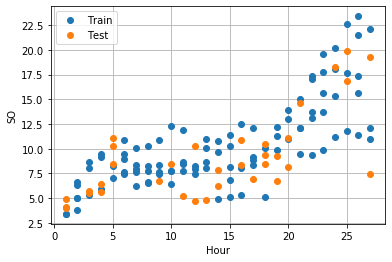

In [338]:
plt.plot(X_train, T_train, 'o', label='Train')
plt.plot(X_test, T_test, 'o', label='Test')
plt.legend();
Tnames = ['SO']                                               
Xnames = ['Hour']
plt.xlabel(Xnames[0])               
plt.ylabel(Tnames[0]);             
plt.grid(True)

In [342]:
Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)
Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)
Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

Best test error is at epoch 50.0 with RMSE Train of 93.67 and Val of 92.92
Percent Correct


,0,1,2,3,4,5,6,7,8,9
0,97.6,0.0,0.2,0.2,0.2,0.5,0.5,0.1,0.6,0.1
1,0.0,97.7,0.4,0.2,0.1,0.3,0.0,0.2,0.9,0.1
2,0.5,0.9,91.9,1.4,1.0,0.3,0.8,1.0,1.9,0.3
3,0.3,0.5,1.8,91.2,0.1,2.6,0.3,0.8,1.8,0.8
4,0.1,0.4,0.5,0.2,94.4,0.1,0.8,0.2,0.5,2.8
5,0.8,0.6,0.6,2.4,0.9,90.4,1.4,0.3,2.0,0.6
6,0.5,0.3,0.4,0.0,0.5,1.0,96.7,0.1,0.4,0.0
7,0.2,0.5,0.9,0.3,0.7,0.1,0.1,94.6,0.2,2.5
8,0.5,2.1,0.9,2.0,0.5,2.1,0.7,0.2,89.9,1.0
9,0.3,0.5,0.3,1.1,2.0,0.6,0.0,2.5,0.6,92.2


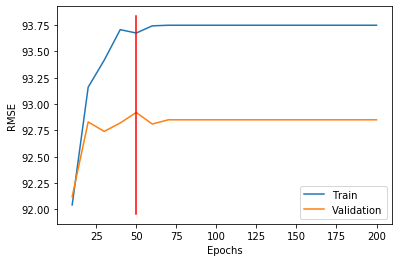

In [26]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain, Xval, Tval,200,10,[],'sgd', 0.01) 
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest], [Ttrain, Tval, Ttest])]
confusion_matrix(nnet.use(Xtrain)[0], Ttrain)

Best test error is at epoch 40.0 with RMSE Train of 93.54 and Val of 92.98
Percent Correct


,0,1,2,3,4,5,6,7,8,9
0,97.6,0.0,0.2,0.2,0.2,0.5,0.6,0.0,0.6,0.1
1,0.0,97.6,0.4,0.3,0.1,0.3,0.0,0.2,0.9,0.1
2,0.6,0.9,91.9,1.4,1.0,0.3,0.8,1.0,1.8,0.3
3,0.3,0.5,1.9,90.9,0.1,2.7,0.3,0.8,1.8,0.8
4,0.2,0.4,0.5,0.1,94.4,0.1,0.8,0.2,0.6,2.8
5,0.8,0.6,0.6,2.3,1.0,90.3,1.4,0.4,2.1,0.6
6,0.6,0.3,0.4,0.0,0.5,1.1,96.5,0.1,0.4,0.1
7,0.2,0.5,0.9,0.3,0.8,0.1,0.1,94.4,0.2,2.6
8,0.6,2.2,1.0,2.0,0.5,2.1,0.7,0.2,89.6,1.1
9,0.3,0.5,0.3,1.1,2.1,0.5,0.0,2.5,0.6,92.0


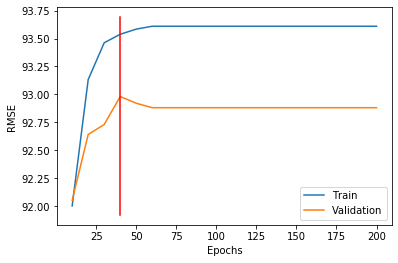

In [27]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain, Xval, Tval,200,10,[],'adam', 0.05) 
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest], [Ttrain, Tval, Ttest])]
confusion_matrix(nnet.use(Xtrain)[0], Ttrain)

Best test error is at epoch 180.0 with RMSE Train of 100.00 and Val of 97.02
Percent Correct


,0,1,2,3,4,5,6,7,8,9
0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0


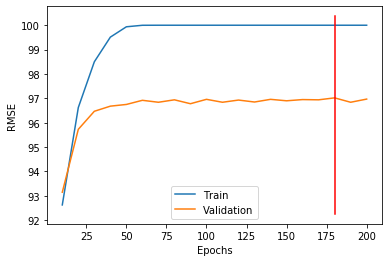

In [21]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 200, 10, [100,100], method='scg') 
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest], [Ttrain, Tval, Ttest])]
confusion_matrix(nnet.use(Xtrain)[0], Ttrain)

# Result

Gradient Descent minimizes the cost function(RMSE) by performing forward and backward propagation for change weights of the neurons. That is why error value reduces to a near zero at certain epoch based on the hidden layer.As Classification is based on structural algorithm,it implies on resulting in a yes/no decisions.As the number of hidden layer increases, the validation rate and accuracy rate decrease. This is because of more hidden layer will tend to get stuck easily with the model, thus ends up being overfitting.Thus, it is preferable to have lesser number of hidden layers for classication of networks.In the case of learning rate, it tend learn a lot as its value is high, but at a certain point it has to minimize in order to unlearn the outliers. Thus, it is necessary for the classifiers to find out the best learning rate with satisfies the model.

# Threat to Validity

Threat to validity is that the run time can differ because ofthe hardware configuration. It is better to run on a cluster or device with higher GPU.